# EDA US Health Insurance

## Import Package

In [28]:
# Lodaing the necessary Libraries.

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.pyplot import figure

from scipy.stats import t
pd.plotting.register_matplotlib_converters()
%matplotlib inline
plt.style.use('seaborn-whitegrid')
pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")

## Load Dataset

In [29]:
data = pd.read_csv('insurance.csv')
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


## Exploratory Data Analysis

### Shape:
shape from the data

In [30]:
print(f'Shape of the data: {data.shape}')
print(f'There are {data.shape[0]} rows in the data.')

Shape of the data: (1338, 7)
There are 1338 rows in the data.


### Data Types:
understanding the data types of various attributes.

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [32]:
# tipe data yang memiliki perbedaan
data.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [33]:
# Check Individual Kolom
data.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [34]:
# Transform the Index object to a series, and grouping by data types:
g = data.columns.to_series().groupby(data.dtypes).groups
g

{int64: ['age', 'children'], float64: ['bmi', 'charges'], object: ['sex', 'smoker', 'region']}

In [35]:
dt = {k.name: v for k, v in g.items()}

atributes_by_datatype = pd.DataFrame(list(dt.values()), index= dt.keys(), columns= ['Attr1', 'Attr2', 'Attr3'])
atributes_by_datatype

,Attr1,Attr2,Attr3
int64,age,children,None
float64,bmi,charges,None
object,sex,smoker,region


In [36]:
# Unique Values for "children":
sorted(data['children'].unique())

[0, 1, 2, 3, 4, 5]

### Data Cleaning:

In [37]:
data.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

no missing data in DataFrame

### Distribution of numerical attributes:
we could get an overview of the important statistics of the data through:

In [38]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [39]:
# Let's construct a function that shows the summary and density distribution of a numerical attribute:
def summary(x):
    x_min = data[x].min()
    x_max = data[x].max()
    Q1 = data[x].quantile(0.25)
    Q2 = data[x].quantile(0.50)
    Q3 = data[x].quantile(0.75)
    print(f'5 Point Summary of {x.capitalize()} Attribute:\n'
          f'{x.capitalize()}(min) : {x_min}\n'
          f'Q1                    : {Q1}\n'
          f'Q2(Median)            : {Q2}\n'
          f'Q3                    : {Q3}\n'
          f'{x.capitalize()}(max) : {x_max}')

    fig = plt.figure(figsize=(14, 10))
    plt.subplots_adjust(hspace = 0.6)
    sns.set_palette('pastel')
    
    plt.subplot(221)
    ax1 = sns.distplot(data[x], color = 'r')
    plt.title(f'{x.capitalize()} Density Distribution')
    
    plt.subplot(222)
    ax2 = sns.violinplot(x = data[x], palette = 'Accent', split = True)
    plt.title(f'{x.capitalize()} Violinplot')
    
    plt.subplot(223)
    ax2 = sns.boxplot(x=data[x], palette = 'cool', width=0.7, linewidth=0.6)
    plt.title(f'{x.capitalize()} Boxplot')
    
    plt.subplot(224)
    ax3 = sns.kdeplot(data[x], cumulative=True)
    plt.title(f'{x.capitalize()} Cumulative Density Distribution')
    
    plt.show()

In [40]:
# Let's take a closer look at the Boxplot, and calculate the measure of skewness and totalnumber of outlier values for various attributes through a function:

def box_plot(x = 'bmi'):
    def add_values(bp, ax):
        """ This actually adds the numbers to the various points of the boxplots"""
        for element in ['whiskers', 'medians', 'caps']:
            for line in bp[element]:
                # Get the position of the element. y is the label you want
                (x_l, y),(x_r, _) = line.get_xydata()
                # Make sure datapoints exist 
                # (I've been working with intervals, should not be problem for this case)
                if not np.isnan(y): 
                    x_line_center = x_l + (x_r - x_l)/2
                    y_line_center = y  # Since it's a line and it's horisontal
                    # overlay the value:  on the line, from center to right
                    ax.text(x_line_center, y_line_center, # Position
                            '%.2f' % y, # Value (3f = 3 decimal float)
                            verticalalignment='center', # Centered vertically with line 
                            fontsize=12, backgroundcolor="white")

    fig, axes = plt.subplots(1, figsize=(4, 8))

    red_diamond = dict(markerfacecolor='r', marker='D')

    bp_dict = data.boxplot(column = x, 
                             grid=True, 
                             figsize=(4, 8), 
                             ax=axes, 
                             vert = True, 
                             notch=False, 
                             widths = 0.7, 
                             showmeans = True, 
                             whis = 1.5,
                             flierprops = red_diamond,
                             boxprops= dict(linewidth=3.0, color='black'),
                             whiskerprops=dict(linewidth=3.0, color='black'),
                             return_type = 'dict')

    add_values(bp_dict, axes)

    plt.title(f'{x.capitalize()} Boxplot', fontsize=16)
    plt.ylabel(f'{x.capitalize()}', fontsize=14)
    plt.show()
    
    skew = data[x].skew()
    Q1 = data[x].quantile(0.25)
    Q3 = data[x].quantile(0.75)
    IQR = Q3 - Q1
    total_outlier_num = ((data[x] < (Q1 - 1.5 * IQR)) | (data[x] > (Q3 + 1.5 * IQR))).sum()
    print(f'Mean {x.capitalize()} = {data[x].mean()}')
    print(f'Median {x.capitalize()} = {data[x].median()}')
    print(f'Skewness of {x}: {skew}.')
    print(f'Total number of outliers in {x} distribution: {total_outlier_num}.')

#### Age Distribution

5 Point Summary of Age Attribute:
Age(min) : 18
Q1                    : 27.0
Q2(Median)            : 39.0
Q3                    : 51.0
Age(max) : 64


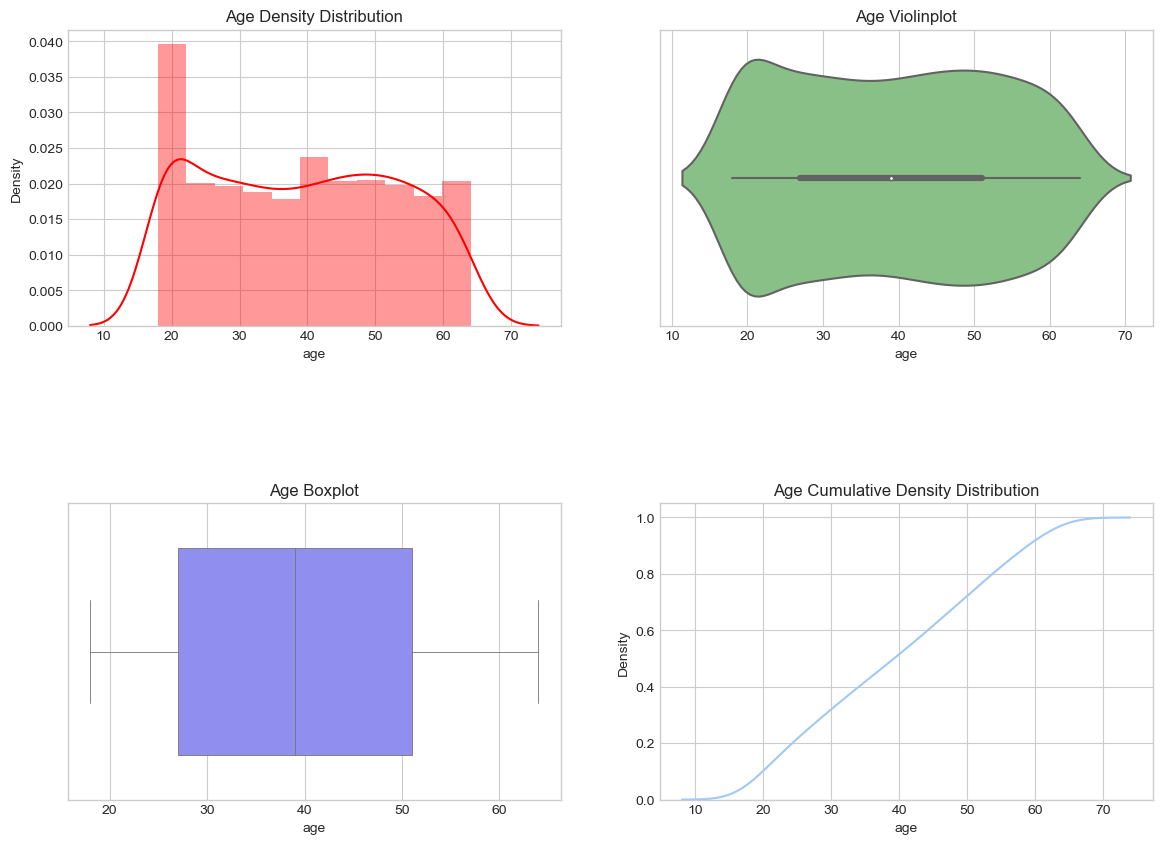

In [41]:
summary('age')

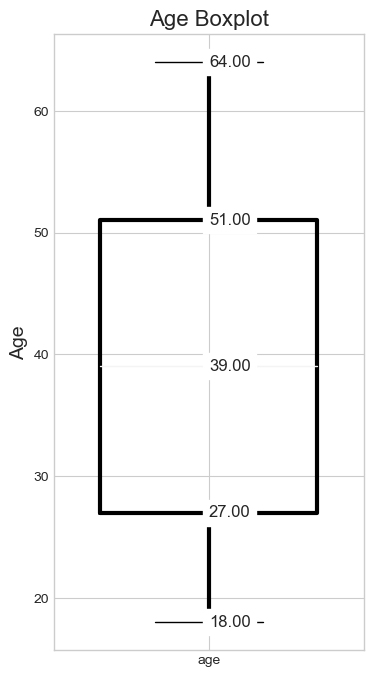

Mean Age = 39.20702541106129
Median Age = 39.0
Skewness of age: 0.05567251565299186.
Total number of outliers in age distribution: 0.


In [42]:
box_plot('age')

In [43]:
df = data[data['age'] == data['age'].max()]
print(df.head())
print()
print(f'Total number of insured people with the age of 64: {len(df)}.')

     age     sex    bmi  children smoker     region      charges
62    64    male  24.70         1     no  northwest  30166.61817
94    64  female  31.30         2    yes  southwest  47291.05500
199   64  female  39.33         0     no  northeast  14901.51670
328   64  female  33.80         1    yes  southwest  47928.03000
335   64    male  34.50         0     no  southwest  13822.80300

Total number of insured people with the age of 64: 22.


#### BMI Distribution

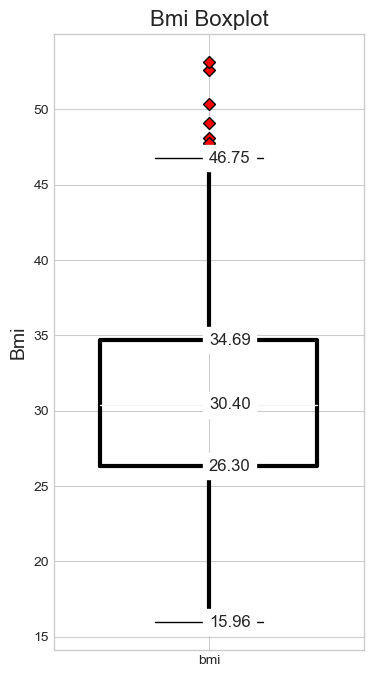

Mean Bmi = 30.663396860986538
Median Bmi = 30.4
Skewness of bmi: 0.2840471105987448.
Total number of outliers in bmi distribution: 9.


In [44]:
box_plot('bmi')

In [45]:
data[data['bmi']==data['bmi'].max()]

,age,sex,bmi,children,smoker,region,charges
1317,18,male,53.13,0,no,southeast,1163.4627


In [46]:
data[data['bmi'] == data['bmi'].min()]

,age,sex,bmi,children,smoker,region,charges
172,18,male,15.96,0,no,northeast,1694.7964


In [47]:
data['charges'].mean(), data['charges'].median()

(13270.422265141257, 9382.033)

5 Point Summary of Charges Attribute:
Charges(min) : 1121.8739
Q1                    : 4740.28715
Q2(Median)            : 9382.033
Q3                    : 16639.912515
Charges(max) : 63770.42801


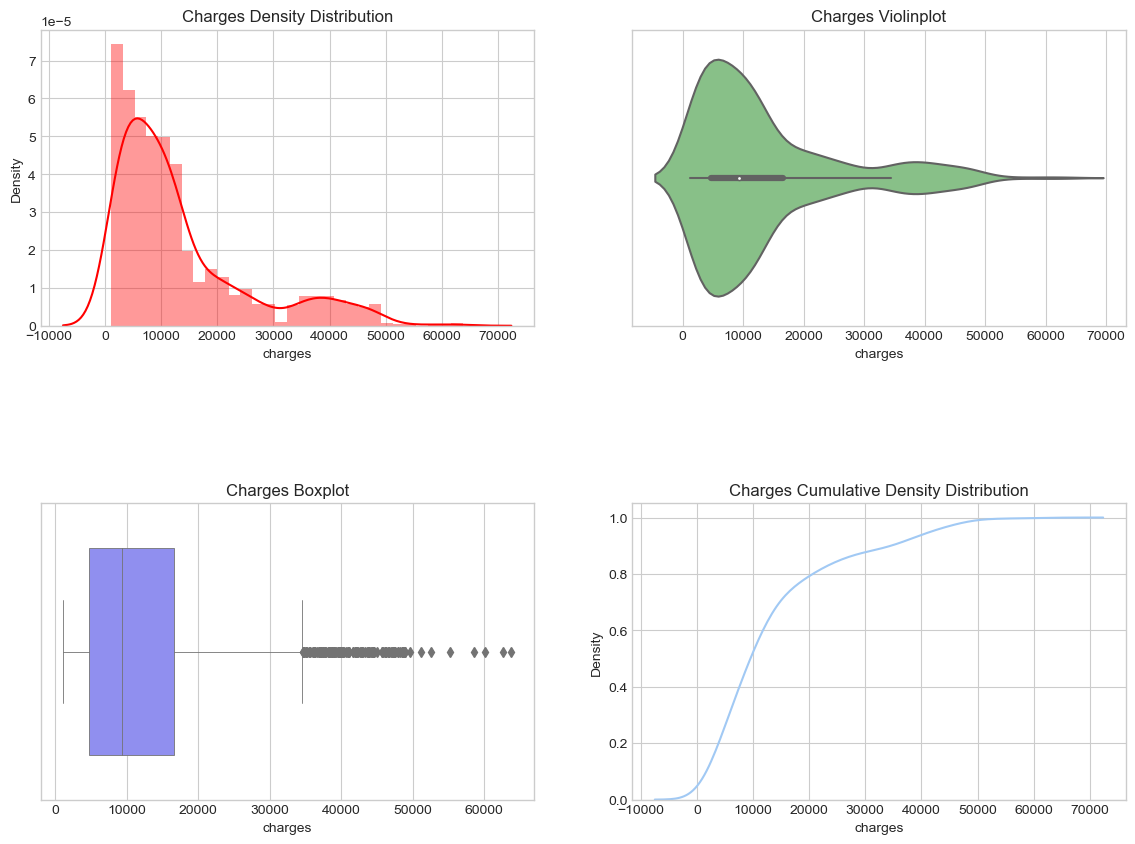

In [48]:
summary('charges')

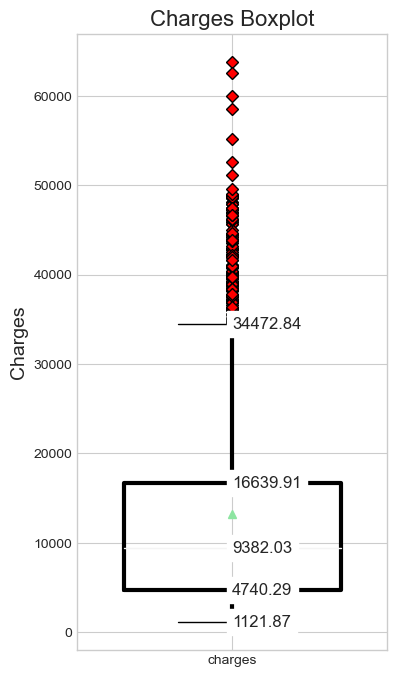

Mean Charges = 13270.422265141257
Median Charges = 9382.033
Skewness of charges: 1.5158796580240388.
Total number of outliers in charges distribution: 139.


In [49]:
box_plot('charges')

In [50]:
# Who is paying the highest charges?
data[data['charges'] == data['charges'].max()]

,age,sex,bmi,children,smoker,region,charges
543,54,female,47.41,0,yes,southeast,63770.42801


In [51]:
# Who is the insured with the highest BMI, and how does his charges compare to the rest?
data[data['bmi'] == data['bmi'].max()]

,age,sex,bmi,children,smoker,region,charges
1317,18,male,53.13,0,no,southeast,1163.4627


In [52]:
data['charges'].mean(), data['charges'].median()

(13270.422265141257, 9382.033)